# Porter: Neural Networks Regression Business Case

**Why is predicting delivery times crucial for Porter?**

Accurately predicting delivery times is vital for Porter because it directly impacts customer satisfaction and operational efficiency. Customers rely on timely deliveries, and when their expectations are met, it enhances their trust in Porter’s services, leading to repeat business and positive word-of-mouth.

On the operational side, better delivery time predictions help Porter optimize resource allocation, such as assigning the right number of delivery partners and managing order dispatches more efficiently. This reduces waiting times, minimizes delays, and ultimately cuts down operational costs. Moreover, by understanding delivery patterns and potential bottlenecks, Porter can continuously improve its logistics processes, leading to a smoother and more reliable service for all stakeholders involved.

### All Libraries Attached

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from mlxtend.plotting import plot_decision_regions
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

### File Reading

In [3]:
df = pd.read_csv("dataset.csv")
df.sample(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
130837,3.0,2015-01-28 02:11:37,2015-01-28 02:45:22,09a5e2a11bea20817477e0b1dfe2cc21,pizza,5.0,3,3500,3,1050,1150,37.0,37.0,37.0
188626,1.0,2015-02-15 02:21:59,2015-02-15 03:35:15,490640b43519c77281cb2f8471e61a71,american,5.0,4,4235,3,400,1400,65.0,65.0,78.0
55765,2.0,2015-02-07 02:51:06,2015-02-07 03:31:13,5737c6ec2e0716f3d8a7a5c4e0de0d9a,italian,3.0,1,2299,1,2299,2299,136.0,110.0,200.0
197090,4.0,2015-01-24 02:52:49,2015-01-24 03:53:24,17e62166fc8586dfa4d1bc0e1742c08b,vietnamese,5.0,3,2245,3,375,995,127.0,121.0,198.0
119086,6.0,2015-02-07 02:06:34,2015-02-07 03:01:46,a2d10d355cdebc879e4fc6ecc6f63dd7,southern,1.0,3,3000,3,850,1300,NaN,NaN,NaN


### Analysing Observations on Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [5]:
df.shape

(197428, 14)

In [6]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
count,196441.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000
mean,2.978706,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065
std,1.524867,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000
75%,4.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000


**"Let's remove the `store_id` column from the dataset, as it does not provide any valuable information for our analysis, and it is not essential for either the exploratory data analysis (EDA) or feature engineering (FE) processes."**

In [7]:
df.drop(columns={"store_id"}, inplace=True)

#### Analysing the Null Values Present in Dataset

In [8]:
df.isna().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
dtype: int64

In [9]:
df['market_id'].value_counts()

market_id
2.0    55058
4.0    47599
1.0    38037
3.0    23297
5.0    18000
6.0    14450
Name: count, dtype: int64

In [10]:
df['market_id'] = df['market_id'].fillna(df['market_id'].mode()[0])

**Here, we observe that most of the market falls under Market ID "2," so it's reasonable to categorize the missing values in the Market ID field based on this most frequent restaurant market.**

In [11]:
df.dropna(subset=['actual_delivery_time'], inplace=True)

**Based on the analysis, the number of null values in the `actual_delivery_time` is minimal. Therefore, altering the data to manipulate these values could introduce bias. Given the small amount of data available, it would be more appropriate to drop these null values from the column.**

In [12]:
print("The Number of Unqiue Values are: ",df['store_primary_category'].nunique(),"\n")
print(df['store_primary_category'].value_counts(), "\n")
print("The total Null values present in Store category is:->" ,df['store_primary_category'].isna().sum())

The Number of Unqiue Values are:  74 

store_primary_category
american             19399
pizza                17320
mexican              17098
burger               10958
sandwich             10059
                     ...  
lebanese                 9
belgian                  2
indonesian               2
chocolate                1
alcohol-plus-food        1
Name: count, Length: 74, dtype: int64 

The total Null values present in Store category is:-> 4760


In [13]:
df['store_primary_category'].fillna("Unknown", inplace=True)

In [14]:
df['order_protocol'].fillna(df['order_protocol'].mode()[0], inplace=True)

In [15]:
df.dropna(subset=['total_onshift_partners'], inplace=True)
df.dropna(subset=['total_busy_partners'], inplace=True)
df.dropna(subset=['total_outstanding_orders'], inplace=True)

**The total_onshift_partners, total_busy_partners , total_outstanding_orders are the features having the most of the missing values, the total of the missing values for these 3 columns are 0.6% of the total data we have, so from the better to deal with the KNN imputation we can drop the number of rows, for better analysis, the 0.6% of data won't be effected for the furthur Analysis**

### Analysing for the duplicated data

In [16]:
df.duplicated().sum()

0

**After the cleaning data set we do not have any duplicated values in the whole data set, which align our best analogy for the prediction and analysing of the data**

### Changing the Data types for their Nature

In [17]:
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['created_at'] = pd.to_datetime(df['created_at'])

## Statistical Summary

In [18]:
df.describe()

,market_id,created_at,actual_delivery_time,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
count,181159.000000,181159,181159,181159.000000,181159.000000,181159.000000,181159.000000,181159.000000,181159.000000,181159.000000,181159.000000,181159.000000
mean,2.744904,2015-02-04 19:32:32.373748992,2015-02-04 20:20:18.677747200,2.886326,3.208469,2698.524296,2.677659,684.850021,1160.752698,44.806866,41.738787,58.047969
min,1.000000,2015-01-21 15:22:03,2015-01-21 15:58:11,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000
25%,2.000000,2015-01-29 01:37:47,2015-01-29 02:25:02.500000,1.000000,2.000000,1415.000000,2.000000,299.000000,799.000000,17.000000,15.000000,17.000000
50%,2.000000,2015-02-05 02:29:20,2015-02-05 03:31:05,3.000000,3.000000,2225.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000
75%,4.000000,2015-02-12 00:49:04,2015-02-12 01:29:45,4.000000,4.000000,3411.000000,3.000000,942.000000,1395.000000,65.000000,62.000000,85.000000
max,6.000000,2015-02-18 06:00:44,2015-02-19 22:45:31,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000
std,1.329398,NaN,NaN,1.517122,2.673052,1829.304441,1.627291,521.291894,561.838633,34.525913,32.145163,52.660056


# Univariate / Bivariate Analysis

**The Market ID represents the area of the restaurant, indicating how the distribution of these areas is implemented across various cities and towns within the dataset. Let's analyze how much area is allocated and distributed, identifying which regions are prominent and fall into the main focus, as well as those that cover less expertise in terms of area distribution.**

market_id
2.0    55704
4.0    47382
1.0    37835
3.0    21676
5.0    17907
6.0      655
Name: count, dtype: int64


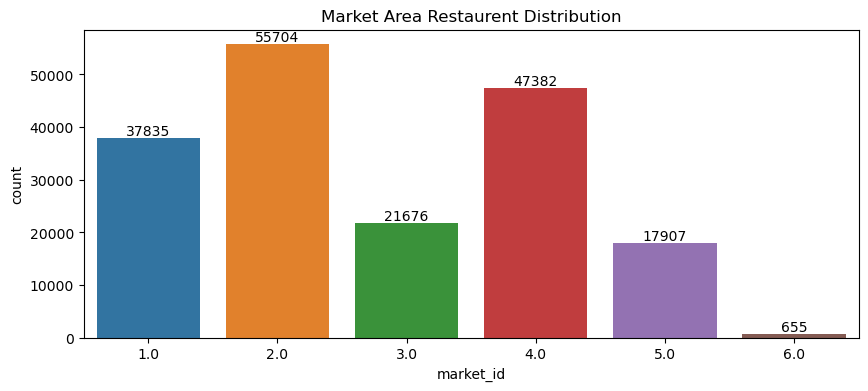

In [19]:
print(df['market_id'].value_counts())
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x="market_id")
ax.bar_label(ax.containers[0])
plt.title("Market Area Restaurent Distribution")
plt.show()

**Based on the analysis, we can observe that Area 2 is a key focus due to the high concentration of people in that region, leading to a significant number of orders originating from there. This is followed by Area 4, which also shows a notable impact according to the analysis.**

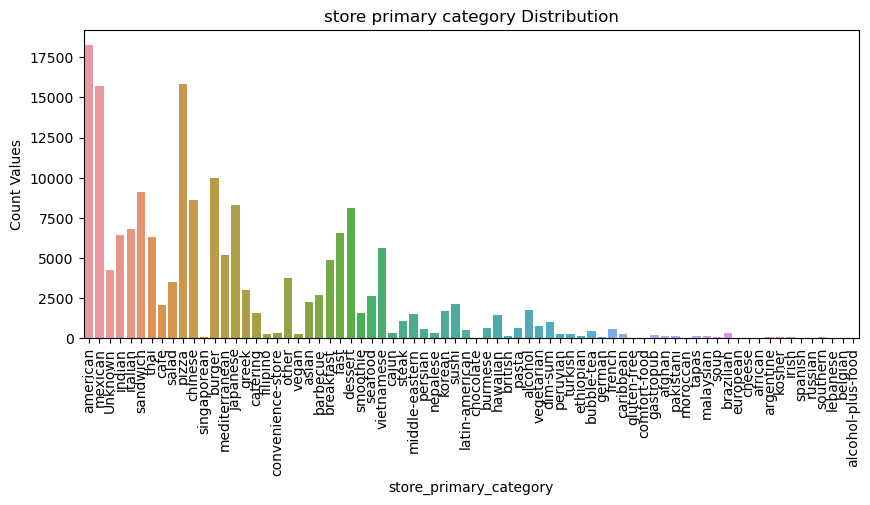

In [20]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x="store_primary_category")
plt.xticks(rotation=90)
plt.ylabel("Count Values")
plt.title("store primary category Distribution")
plt.show()

**The graph illustrates the distribution of food categories based on the dataset. It highlights that American and Pizza are the most frequently ordered foods, indicating a significant preference for these categories. This is followed by Mexican cuisine, which also ranks highly in popularity and demand. These insights suggest that American, Pizza, and Mexican foods are the dominant choices among consumers.**

                count
order_protocol       
1.0             51481
3.0             48031
5.0             41995
2.0             21348
4.0             17602
6.0               683
7.0                19


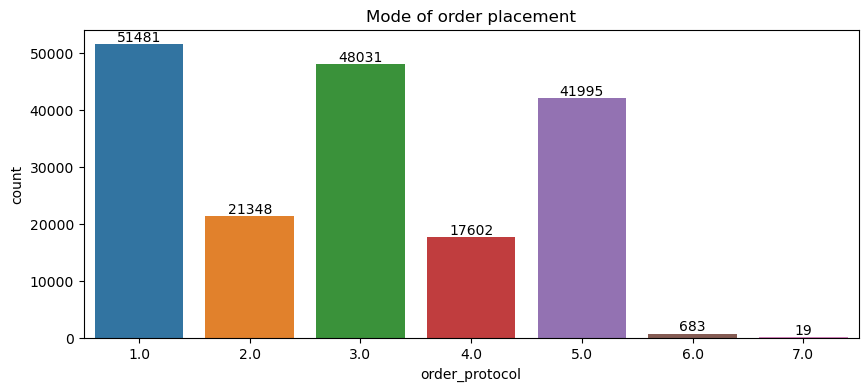

In [21]:
print(df['order_protocol'].value_counts().to_frame())
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x="order_protocol")
ax.bar_label(ax.containers[0])
plt.title("Mode of order placement")
plt.show()

**The majority of orders fall under categories 1.0, 2.0, and 5.0, with most customers choosing the category 1.0 option, which represents ordering through Porter. This indicates that the Porter option is the most popular choice among customers.**

### Analysing top Restaurants Generating Revenue

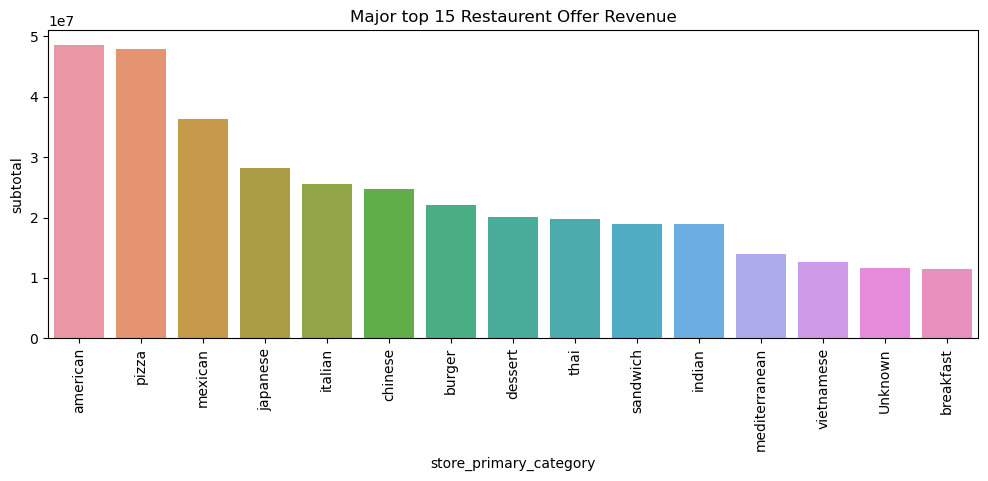

In [22]:
major_restaurent= df.groupby(by=["store_primary_category"])['subtotal'].sum().reset_index()
major_restaurent = major_restaurent.sort_values(by="subtotal", ascending=False)[:15]
plt.figure(figsize=(12,4))
ax =sns.barplot(data=major_restaurent, x="store_primary_category", y="subtotal")
# ax.bar_label(ax.containers[0])
plt.title("Major top 15 Restaurent Offer Revenue")
plt.xticks(rotation=90)
plt.show()

**The graph highlights that the majority of restaurants on the platform generate the highest revenue from American and Pizza cuisines, which are consistently popular choices among customers. Additionally, Mexican and Italian cuisines also contribute significantly to the platform's revenue, as they are frequently selected by customers. Notably, Indian food ranks among the top 10 categories, further driving substantial revenue for the platform.**

### Insights for Maximum Food Orders

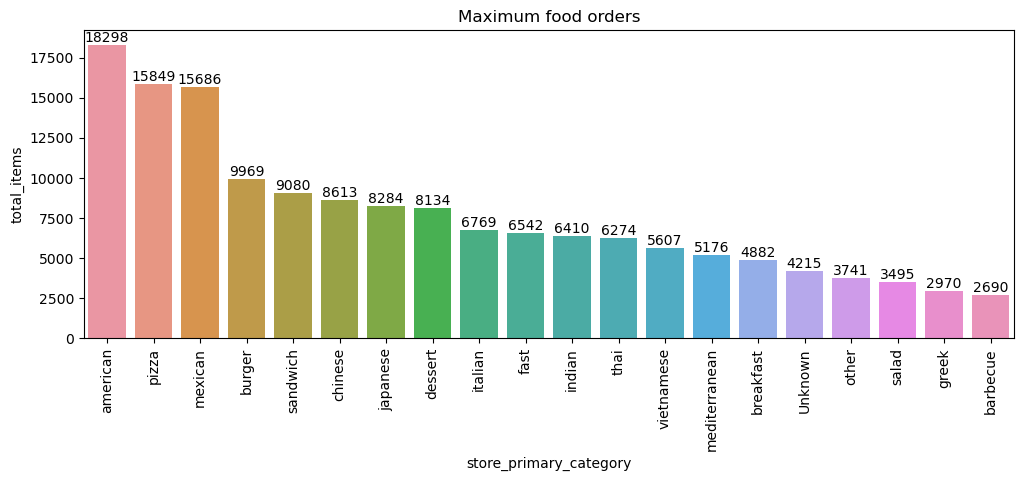

In [23]:
restaurant_classification_count = df.groupby(by=["store_primary_category"])['total_items'].count().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,4))
ax =sns.barplot(data=restaurant_classification_count[:20], x="store_primary_category", y="total_items")
ax.bar_label(ax.containers[0])
plt.title("Maximum food orders")
plt.xticks(rotation=90)
plt.show()

**This analysis focuses on identifying the most popular food categories, with American cuisine and pizza emerging as the top choices among people. The top 15 categories also include salad, barbecue, Italian, and dessert, which are significant in understanding the cultural preferences in food. This insight is crucial for predicting food trends and preferences.**

### Analysing the Area Generating Revenue

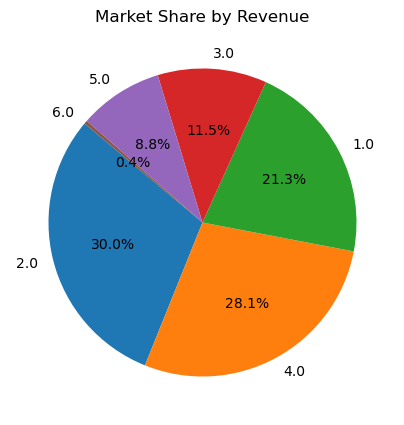

In [24]:
market_revenue= df.groupby(by=["market_id"])['subtotal'].sum().reset_index()
market_revenue = market_revenue.sort_values(by="subtotal", ascending=False)[:15]
plt.figure(figsize=(5, 5))
plt.pie(market_revenue['subtotal'], labels=market_revenue['market_id'], autopct='%1.1f%%', startangle=140)
plt.title('Market Share by Revenue')
plt.show()

**The pie chart illustrates the market share distribution by location, highlighting where restaurants are predominantly situated. The analysis reveals that the highest volume of orders originates from Area 2.0, followed by Area 4.0. Additionally, Area 1.0 contributes 21.3% of the total orders. These areas are home to the majority of active restaurants, generating significant revenue and profit for their businesses.**

## Analysing time and Extracting Delivery Time and Day week FE

In [25]:
df["Delivery_time"] = (df['actual_delivery_time'] - df['created_at'])/ pd.Timedelta("60s")

In [26]:
df['hour'] = df['created_at'].dt.hour
df['week'] = df['created_at'].dt.dayofweek

**In this project, we have identified and extracted the key features from the date columns. As these columns no longer contribute significantly to our analysis, we will proceed by removing them to streamline our data for further analysis.**

In [27]:
df.drop(columns={"created_at","actual_delivery_time"}, inplace=True)

**Based on my analysis, the feature "store_primary_category" is crucial for further investigation, particularly in relation to food. This is because food plays a significant role in predicting delivery times. Different types of food require varying preparation times, which impacts the overall delivery time. By incorporating the "store_primary_category" feature, we can more accurately account for these variations and enhance the prediction of delivery times. This feature will be used as a reference point in our analysis to ensure more precise and reliable results. generating it below & it will give every category of food to its unique code**

In [28]:
df['store_primary_category']=df['store_primary_category'].astype('category').cat.codes

### Delivery time Statistics

In [29]:
print(df['Delivery_time'].describe().to_frame())

       Delivery_time
count  181159.000000
mean       47.771733
std        27.456480
min         1.683333
25%        35.083333
50%        44.366667
75%        56.383333
max      6231.316667


### Correlating Features

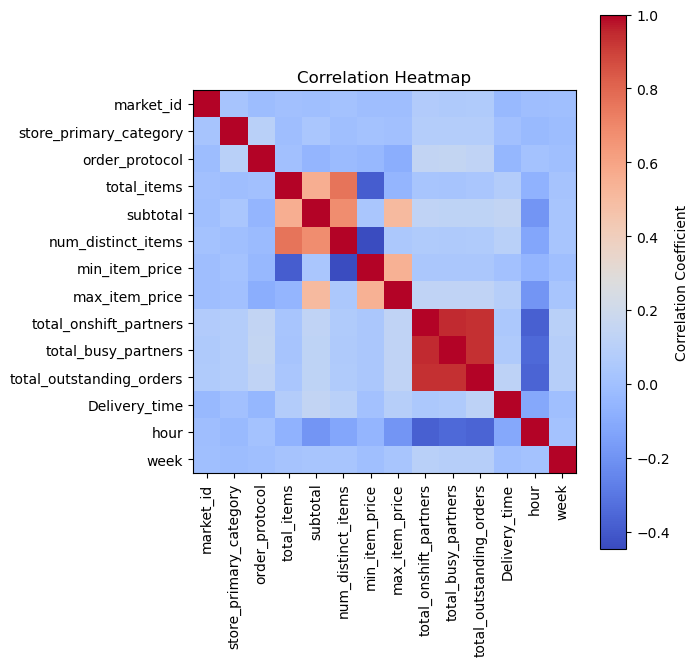

In [30]:
corr_matrix = df.corr()
plt.figure(figsize=(7,7))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Heatmap')
plt.xticks(ticks=range(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90)
plt.yticks(ticks=range(len(corr_matrix.columns)), labels=corr_matrix.columns)
plt.tight_layout()
plt.show()

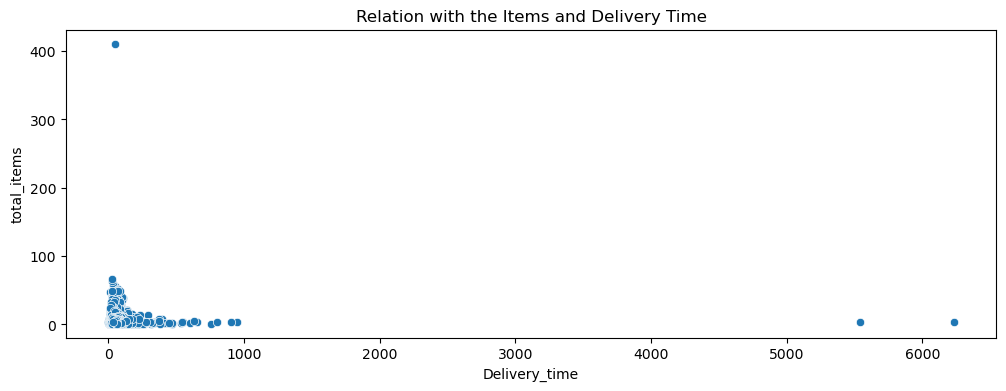

In [31]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=df, x="Delivery_time", y="total_items")
plt.title("Relation with the Items and Delivery Time")
plt.show()

**we analyze the delivery times and item handling to address inefficiencies. The current average delivery time of 41 minutes exceeds expectations. To improve, we will coordinate with partners who are available and strategically allocate resources to streamline the delivery process. This will help reduce the delivery times and enhance customer satisfaction.**

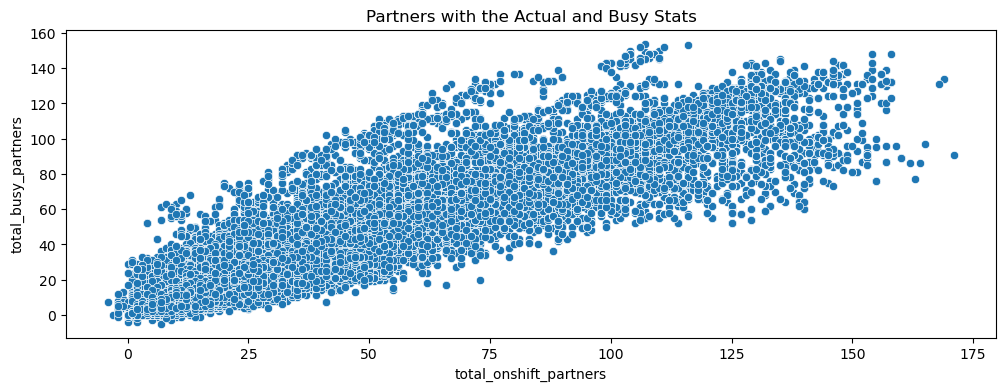

In [32]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=df, x="total_onshift_partners", y="total_busy_partners")
plt.title("Partners with the Actual and Busy Stats")
plt.show()

**The scatter plot illustrates a positive correlation between the number of on-shift partners (`total_onshift_partners`) and busy partners (`total_busy_partners`). As the number of on-shift partners increases, the number of busy partners also rises, indicating that a higher on-shift workforce corresponds to more partners being engaged. The data points generally follow an upward linear trend, although there is some variability, suggesting that the proportion of busy partners varies depending on other factors. This relationship is crucial for optimizing workforce management and ensuring an adequate distribution of workload among available partners.**

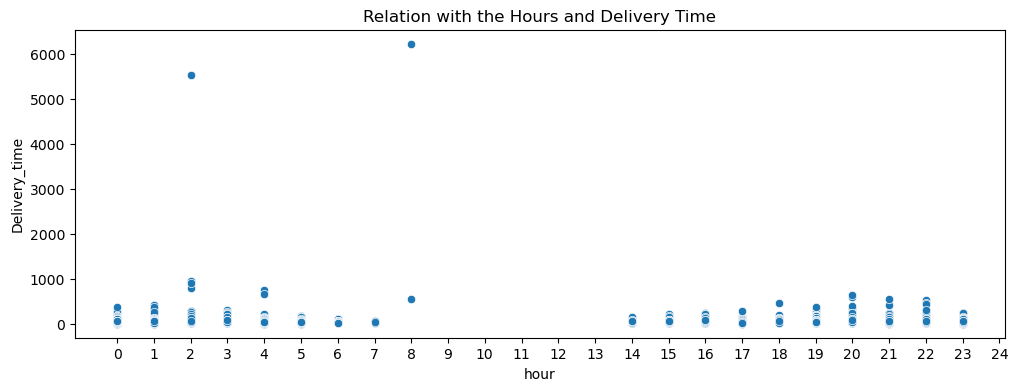

In [33]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=df, x="hour", y="Delivery_time")
plt.title("Relation with the Hours and Delivery Time")
plt.xticks(np.arange(0,25))
plt.show()

**We can observe that the majority of orders are placed during the evening and night, with some orders also occurring in the morning between 1 to 4 AM. Additionally, there are a few orders placed at very unusual times, but their delivery times are significantly higher, which should be considered as outliers in the data.**

### Items and Busy Partners Relationship

In [34]:
# Extract relevant columns
order_volumes = df['total_items']
busy_partners = df['total_busy_partners']

# Calculate the correlation coefficient
correlation = order_volumes.corr(busy_partners)

print(f"The correlation coefficient between order volumes and the number of busy partners: {correlation:.2f}")

The correlation coefficient between order volumes and the number of busy partners: 0.03


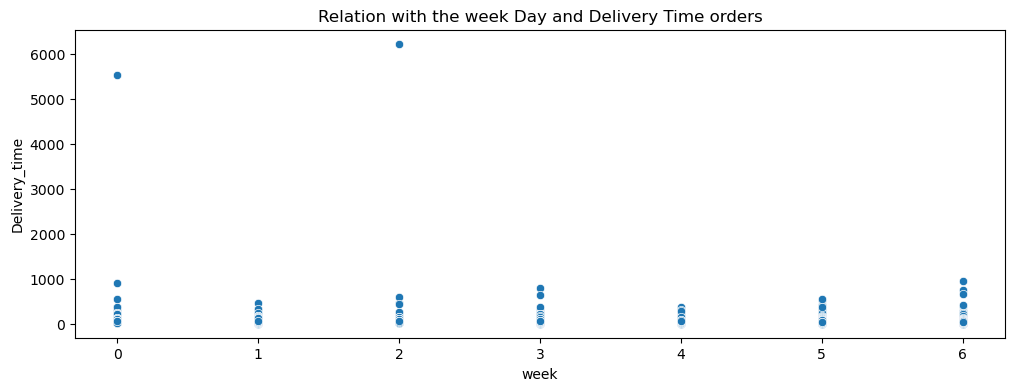

In [35]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=df, x="week", y="Delivery_time")
plt.title("Relation with the week Day and Delivery Time orders")
plt.show()

**Almost all the orders are being considered the same across all the weeks in terms of delivery time for this analysis. This is because we observe consistent delivery times across all the weeks.**

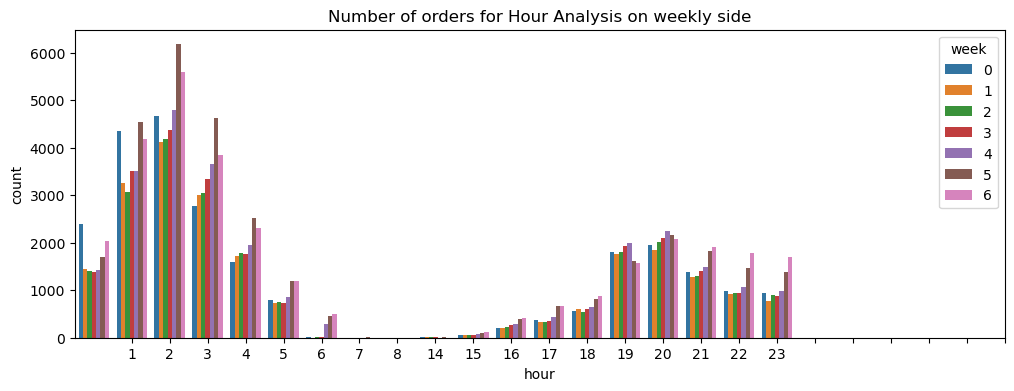

In [36]:
plt.figure(figsize=(12,4))
sns.countplot(data=df,x='hour', hue="week")
plt.title("Number of orders for Hour Analysis on weekly side")
plt.xticks(np.arange(1,25))
plt.show()

**Here, we have a deep understanding of the order patterns across different hours and a weekly analysis. We can assume that the majority of orders are placed around 2 AM in the 5th week, which is the last week of the month. Additionally, insights reveal that people tend to place more orders late at night compared to the morning or afternoon on any given week. Moreover, the 5th day of each week sees a higher volume of orders, likely due to it being a Saturday when most people place their orders.**

## Analysing Outliers

**Using Z-Score**

In [37]:
df['z-score'] = np.abs((df['Delivery_time'] - df['Delivery_time'].mean()) / df['Delivery_time'].std())

# Setting a threshold for identifying outliers
outliers = df[df['z-score'] > 2]

print("Outliers:")
print(outliers[['Delivery_time', 'z-score']])

Outliers:
        Delivery_time   z-score
11         134.450000  3.156933
289        108.033333  2.194804
458        113.100000  2.379339
459        131.033333  3.032494
512        103.883333  2.043656
...               ...       ...
197353     112.166667  2.345346
197371     107.783333  2.185699
197382     105.233333  2.092825
197386     105.100000  2.087969
197414     134.566667  3.161182

[2439 rows x 2 columns]


Mean for z-score is:  0.5027785111626996


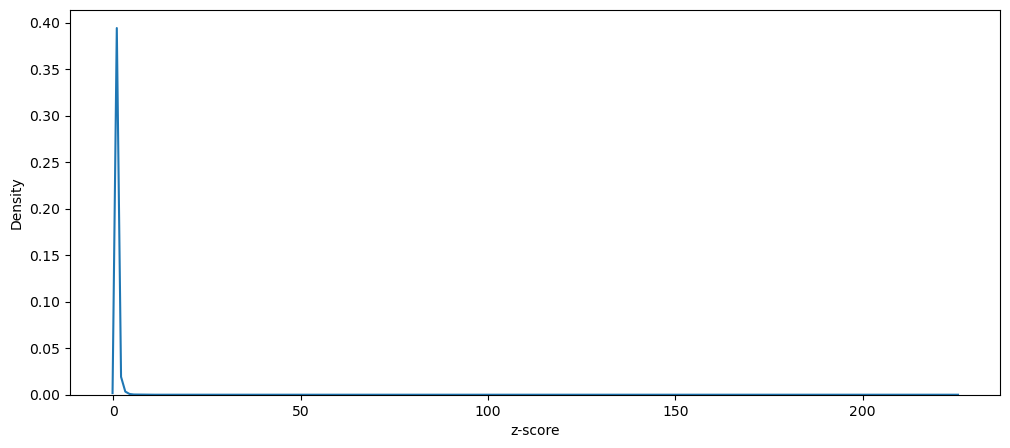

In [38]:
plt.figure(figsize=(12,5))
print("Mean for z-score is: ",df['z-score'].mean())
sns.kdeplot(data=df, x="z-score")
plt.show()

**Based on our analysis, we've observed that the mean delivery time is clustered around 0.5 minutes, with the majority of the data points falling above the mean. The distribution is notably right-skewed, and there are numerous outliers in the dataset. Given this, when designing the neural network model for predicting delivery times, it's important to retain all data points. This will allow for more thorough inspection and improve the model's learning process.**

### visualize using boxplots

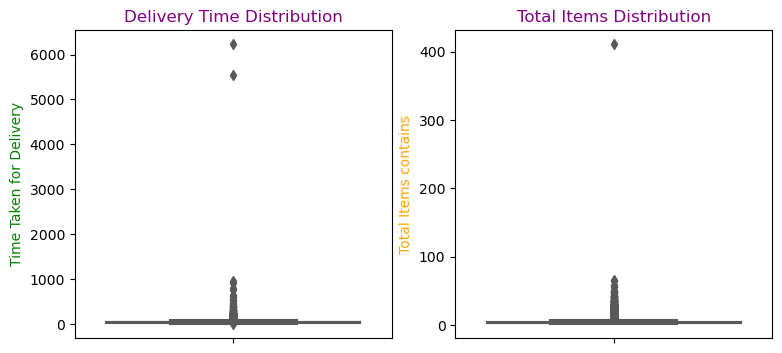

In [39]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
palette = sns.color_palette("Set2")
sns.boxplot(y='Delivery_time', data=df, palette=palette)
plt.xticks(rotation=90, color='blue')
plt.ylabel('Time Taken for Delivery', color='green')
plt.title('Delivery Time Distribution', color='purple')

plt.subplot(1,2,2)
palette = sns.color_palette("Set2")
sns.boxplot(y='total_items', data=df, palette=palette)
plt.xticks(rotation=90, color='blue')
plt.ylabel('Total Items contains', color='orange')
plt.title('Total Items Distribution', color='purple')
plt.show()

**When identifying outliers, particularly those representing extremely long delivery times, it's important to address them since such scenarios are rare and unlikely to reflect typical conditions. The best approach to handle these outliers is to remove them from the dataset. This ensures that the dataset remains robust and suitable for training models, particularly when creating deep neural networks.**

### Removing Outliers Using IQR

In [40]:
Q1 = df['Delivery_time'].quantile(0.25)
Q3 = df['Delivery_time'].quantile(0.75)
print("The 25th quartile of Data: ",round(Q1))
print("The 75th quartile of Data: ",round(Q3))

The 25th quartile of Data:  35
The 75th quartile of Data:  56


In [41]:
IQR = Q3 - Q1
print("The Inter Quartile Range is: ", IQR)

The Inter Quartile Range is:  21.299999999999997


In [42]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Lower bound values :", lower_bound)
print("upper bound values :", upper_bound)

Lower bound values : 3.13333333333334
upper bound values : 88.33333333333333


In [43]:
cleaned = df[~((df['Delivery_time'] < lower_bound) | (df['Delivery_time'] > upper_bound))]
cleaned.shape

(175461, 15)

In [44]:
outliers = (df.shape[0] - cleaned.shape[0]) / df.shape[0] * 100
print(f"{outliers:.2f}% of the data was removed as outliers.")

3.15% of the data was removed as outliers.


**After removing the outliers from the dataset, we've reduced the data by approximately 3.15%. This process has helped us address the issue of outliers, resulting in a clean dataset free of outliers. This refined dataset is now well-prepared for model creation, ensuring better performance and more reliable results.**

In [45]:
df = cleaned
df.shape

(175461, 15)

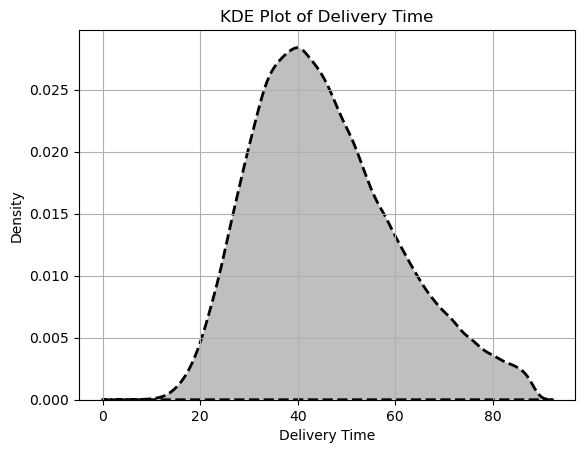

In [46]:
sns.kdeplot(data=cleaned['Delivery_time'], 
            color='grey',
            shade=True,    
            alpha=0.5,     
            linestyle='--',
            linewidth=2,
            fill=True,     
            multiple='stack')
plt.xlabel('Delivery Time')
plt.ylabel('Density')
plt.title('KDE Plot of Delivery Time')
plt.grid(True)
plt.show()

**After cleaning the dataset, it’s evident that the average delivery time for the Food category is approximately 40 minutes. Previously, the mean was significantly lower due to the presence of outliers, which skewed the data to the right and led to inaccurate conclusions. By addressing these outliers, we were able to correct the skewness and achieve a more accurate and representative average delivery time.**

In [47]:
df.sample(3)

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Delivery_time,hour,week,z-score
1569,4.0,29,3.0,3,2403,3,399,639,45.0,71.0,71.0,41.350000,20,5,0.233888
112913,3.0,8,1.0,2,3598,1,1799,1799,0.0,0.0,0.0,45.000000,1,3,0.100950
169116,1.0,56,5.0,1,649,1,649,649,9.0,10.0,8.0,35.116667,22,3,0.460914


# Prepration of model for Deep Neural Network

In [48]:
y = df['Delivery_time'] #Target varibale (feature)

In [49]:
X = df.drop(columns={"Delivery_time","z-score"})

**Here, we have prepared the target and input features for training the model. Let's proceed by splitting the data into training and testing sets as required. We should also scale and transform the data to values between 0 and 1 to enhance the model's performance and ensure better insights for the business.**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [51]:
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of testing features: {X_test.shape}")
print(f"Shape of training target: {y_train.shape}")
print(f"Shape of testing target: {y_test.shape}")

Shape of training features: (140368, 13)
Shape of testing features: (35093, 13)
Shape of training target: (140368,)
Shape of testing target: (35093,)


In [52]:
scaling = StandardScaler()
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)

### General Model

In [53]:
Model = Sequential()

In [54]:
sgdopt=keras.optimizers.SGD(
    learning_rate=0.2)

In [55]:
Model.add(Dense(10,input_shape=(X_train.shape[1],),activation=lambda x: keras.activations.relu(x,negative_slope=0.01)))
#second hidden layer
Model.add(Dense(5,activation='tanh'))
Model.add(Dense(1))

In [56]:
Model.compile(loss='mean_squared_error', optimizer=sgdopt, metrics=['mean_absolute_error', 'RootMeanSquaredError'])

In [57]:
Model.fit(X_train,y_train,epochs=20,batch_size=32,validation_split=0.2)

Epoch 1/20
3510/3510 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - RootMeanSquaredError: nan - loss: nan - mean_absolute_error: nan - val_RootMeanSquaredError: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
3510/3510 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - RootMeanSquaredError: nan - loss: nan - mean_absolute_error: nan - val_RootMeanSquaredError: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/20
3510/3510 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - RootMeanSquaredError: nan - loss: nan - mean_absolute_error: nan - val_RootMeanSquaredError: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/20
3510/3510 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - RootMeanSquaredError: nan - loss: nan - mean_absolute_error: nan - val_RootMeanSquaredError: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/20
3510/3510 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - RootMeanSquaredError: nan - loss: nan - mean_absolute_error: nan - val_RootMeanSquaredError: nan - val_loss: nan - val_mean_absolute_error: nan


KeyboardInterrupt: 

In [ ]:
Model.summary()

**The model summary indicates a simple sequential neural network with three dense layers. The first layer has 10 neurons and an input size of 14 features, with 140 trainable parameters. The second layer reduces the dimensionality to 5 neurons with 55 parameters, and the final output layer consists of a single neuron with 6 parameters. The total number of trainable parameters is 201, indicating a relatively small model, which may contribute to underfitting, as seen from the previous analysis. The model's simplicity suggests it may struggle to capture complex patterns in the data, highlighting the need for a more robust architecture or additional feature engineering to improve performance.**

In [ ]:
prediction = Model.predict(X_test)
prediction[:5]

In [ ]:
prediction = prediction.flatten()
prediction.shape

In [ ]:
Deliveryprediction = pd.DataFrame({
    'Predictions': prediction,
    'Actual': y_test
})
Deliveryprediction

**The analysis shows a significant disparity between the predicted and actual values, indicating that the model is not performing well. The predictions are consistently low compared to the actual values, suggesting that the model may be underfitting. This could be due to insufficient training data, a model that is too simple, or improper feature selection. To address this issue, we could consider gathering more data, using a more complex model, tuning hyperparameters, or performing feature engineering. Additionally, evaluating the model with other metrics, such as R-squared or mean absolute error, may provide further insights into its performance.**

## Analysing using Baseline structure of model

In [ ]:
model = Sequential([
    Dense(64, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1],)),
    Dense(516, activation='relu'),
    Dense(1024,activation='relu'),
    Dense(256,activation='relu'),
    Dense(1,activation='linear')
])

In [ ]:
adam=Adam(learning_rate=0.01)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])

history = model.fit(X_train,y_train,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**Based on the epochs we've run, the training loss and validation loss are nearly aligned, indicating that the model isn't overfitting. However, our assumptions reveal that both the MSE (Mean Squared Error) and MAE (Mean Absolute Error) are relatively high, along with elevated loss values. To improve the model's performance, we should consider applying regularization techniques to optimize the current values and achieve better results.**

In [ ]:
model.summary()

In [ ]:
z = model.predict(X_test)

In [ ]:
z =z.flatten()
z

In [ ]:
Baseline_prediction = pd.DataFrame({
    'Predictions': z,
    'Actual': y_test
})
Baseline_prediction

**Based on our assumptions, the predictions closely align with the actual values. This indicates that our model is performing well, as the majority of the values are accurately predicted. The analysis shows that the model is well-trained and produces reliable predictions, confirming its effectiveness.**

### Preparing Model with Hyperparameter Tuning using Regularisation

In [ ]:
reg1=keras.regularizers.L1(l1=0.01)
reg2=keras.regularizers.L2(l2=0.01)

In [ ]:
model=Sequential()
model.add(Dense(64,activation='relu',kernel_initializer='normal',input_shape=(X_train.shape[1],),kernel_regularizer='l1')),
model.add(Dense(516,activation='relu',kernel_regularizer='l2')),
model.add(Dense(64, activation="relu")),
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

In [ ]:
adam=Adam(learning_rate=0.01)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])

history = model.fit(X_train,y_train,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**After applying "L1" and "L2" regularization, the model's performance has improved compared to the previous baseline models. The graph shows that the training loss decreases significantly by the final iteration, and the model's ability to predict new data has improved. The accuracy of this regularized model surpasses that of the baseline models. Now, let's examine the actual and predicted values for this enhanced model.**

In [ ]:
predict = model.predict(X_test)

In [ ]:
predict = predict.flatten()
predict

In [ ]:
Reg_prediction = pd.DataFrame({
    'Predictions': predict,
    'Actual': y_test
})
Reg_prediction

## Model Accuracy

In [ ]:
test_loss,mse,mae=model.evaluate(X_test,y_test)

In [ ]:
print("The test loss comes out to be: ",test_loss)
print("The mean sqaured error is: ",mse)
print("The mean Absolute Error is: ",mae)

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predict)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predict)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Calculate R-squared (R2 Score)
r2 = r2_score(y_test, predict)
print(f'R-squared (R2 Score): {r2:.4f}')

## Preparing Model with Hyperparameter Tuning using Regularisation and Dropout

In [ ]:
reg1=keras.regularizers.L1(l1=0.01)
reg2=keras.regularizers.L2(l2=0.01)

In [ ]:
model=Sequential()
model.add(Dense(64,activation='relu',kernel_initializer='normal',input_shape=(X_train.shape[1],),kernel_regularizer='l1')),
model.add(Dense(516,activation='relu',kernel_regularizer='l2')),
Dropout(0.2),
model.add(Dense(64, activation="relu",kernel_regularizer='l2')),
Dropout(0.2),
model.add(Dense(32,activation="relu", kernel_regularizer='l2')),
Dropout(0.2),
model.add(Dense(1,activation='linear'))

In [ ]:
model.summary()

In [ ]:
adam=Adam(learning_rate=0.01)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])

history = model.fit(X_train,y_train,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
test_loss,mse,mae=model.evaluate(X_test,y_test)

**We noted that applying Dropout to neurons and using regularization for hyperparameter tuning resulted in higher values compared to the previous model without Dropout. However, despite utilizing both regularization and Dropout, we did not observe a significant increase in instances within the deep neural network.**

## Lets Analyse with the Help of the Bacth Normalisation

In [ ]:
reg1=keras.regularizers.L1(l1=0.01)
reg2=keras.regularizers.L2(l2=0.01)
model=Sequential()
model.add(Dense(64,activation='relu',kernel_initializer='normal',input_shape=(X_train.shape[1],),kernel_regularizer='l1')),
BatchNormalization(),
model.add(Dense(516,activation='relu',kernel_regularizer='l2')),
BatchNormalization(),
Dropout(0.2),
model.add(Dense(128, activation="relu",kernel_regularizer='l2')),
BatchNormalization(),
Dropout(0.2),
model.add(Dense(64,activation="relu")),
model.add(Dense(32,activation="relu")),
model.add(Dense(1,activation='linear'))

In [ ]:
adam=Adam(learning_rate=0.001)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])

history = model.fit(X_train,y_train,epochs=40,batch_size=500,verbose=1,validation_split=0.2)

**Through the application of Batch Normalization and regularization, we achieved a balanced model with a reasonable accuracy and loss. Although the improvement in MSE and MAE was modest, the model effectively avoids overfitting and underfitting, as demonstrated in the graph below.**

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.summary()

## Early Stopping with using all hyperparameter tuning

In [ ]:
reg1=keras.regularizers.L1(l1=0.01)
reg2=keras.regularizers.L2(l2=0.01)
model=Sequential()
model.add(Dense(64,activation='relu',kernel_initializer='normal',input_shape=(X_train.shape[1],),kernel_regularizer='l1')),
BatchNormalization(),
model.add(Dense(516,activation='relu',kernel_regularizer='l2')),
BatchNormalization(),
Dropout(0.2),
model.add(Dense(128, activation="relu",kernel_regularizer='l2')),
BatchNormalization(),
Dropout(0.2),
model.add(Dense(64,activation="relu")),
model.add(Dense(32,activation="relu")),
model.add(Dense(1,activation='linear'))

In [ ]:
adam=Adam(learning_rate=0.001)
model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [ ]:
history = model.fit(X_train,y_train,epochs=60,callbacks=callback,batch_size=500,verbose=1,validation_split=0.2)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**We observed that the loss was reduced using techniques like hyperparameter tuning and regularization. Additionally, by increasing the number of epochs, the training process was extended, resulting in lower loss values compared to previous iterations. The combination of hyperparameter tuning and an increased number of epochs significantly improved the model's accuracy, leading to better MSE, MAE, and overall loss metrics than the earlier model.**

# Questionnaire

## 1. Defining the problem statements and where can this and modifications of this be used?

### **Problem Statement**

The primary problem Porter faces is predicting delivery times accurately. Accurate delivery time predictions are crucial for maintaining customer satisfaction, optimizing logistics operations, and enhancing overall service efficiency. The goal is to develop a model using neural networks that can estimate delivery times based on various attributes such as market area, order details, and delivery partner availability.

### **Where Can This Be Used?**

1. **Improving Customer Experience:**
   - Accurate delivery time predictions help manage customer expectations. When customers are informed of realistic delivery times, it leads to higher satisfaction and trust in the service.
  
2. **Resource Optimization:**
   - By predicting delivery times, Porter can optimize the allocation of delivery partners, reducing idle time and improving the utilization of resources. This helps in managing costs and increasing operational efficiency.

3. **Dynamic Pricing Models:**
   - Accurate predictions can be integrated into dynamic pricing models, where delivery charges can vary based on the expected delivery time, distance, and current demand. This can lead to more efficient pricing strategies.

4. **Logistics Planning and Route Optimization:**
   - Predictive models can be used to plan better delivery routes, especially during peak times. By understanding the factors that cause delays, Porter can reroute or reschedule deliveries to ensure faster service.

5. **Scalability and Expansion:**
   - As Porter expands to new markets or regions, the model can be modified and retrained with new data to ensure it continues to predict delivery times accurately, taking into account regional differences in traffic, order density, and other factors.

6. **Operational Improvements:**
   - Insights from the model can identify bottlenecks in the delivery process, such as areas with consistently longer delivery times. This allows Porter to make informed decisions about where to improve infrastructure or change operational strategies.

### **Modifications for Broader Applications:**

- **Regional Customization:**
  - The model can be adjusted to account for regional differences in traffic patterns, infrastructure, and customer behavior. This ensures the predictions remain accurate as Porter expands its services.

- **Incorporating Real-Time Data:**
  - Modifying the model to include real-time data, such as current traffic conditions or weather, can further improve the accuracy of delivery time predictions.

- **Multi-Modal Deliveries:**
  - If Porter decides to integrate other forms of delivery (like drones or autonomous vehicles), the model can be adapted to handle the different delivery speeds and conditions associated with these modes.

## 2. List 3 functions the pandas datetime provides with one line explanation.

### **Three Pandas `datetime` Functions:**

1. **`pd.to_datetime()`**: Converts a string or object to a `datetime` object, enabling easier manipulation and analysis of date and time data.

2. **`datetime.dt.dayofweek()`**: Formats `datetime` objects into specific week representations, such as converting a date to "YYYY-MM-DD" format as result it out into the Week of the Date

3. **`datetime.dt.hour`**: Extracts the hour from a `datetime` object, useful for analyzing time-based trends or patterns in the data.

## 3. Short note on datetime, timedelta, time span (period)

### `datetime`

- **Purpose**: Represents points in time.
- **Module**: Part of the `datetime` module.
- **Key Classes**:
  - `datetime`: Combines date and time.
    - **Attributes**: year, month, day, hour, minute, second, microsecond.
    - **Example**: `datetime.datetime(2024, 8, 30, 12, 0, 0)`
  - `date`: Represents a date (year, month, day).
    - **Example**: `datetime.date(2024, 8, 30)`
  - `time`: Represents a time of day (hour, minute, second, microsecond).
    - **Example**: `datetime.time(12, 0, 0)`

### `timedelta`

- **Purpose**: Represents a duration or difference between two dates/times.
- **Module**: Part of the `datetime` module.
- **Key Attributes**:
  - `days`: Number of days.
  - `seconds`: Number of seconds.
  - `microseconds`: Number of microseconds.
- **Example**: `datetime.timedelta(days=10, hours=5)` represents a duration of 10 days and 5 hours.
- **Usage**: Can be added to or subtracted from `datetime` objects to compute new dates/times.

### Time Span (Period)

- **Purpose**: Represents a period or span of time, often used in context with `pandas` for handling data over intervals.
- **Module**: `pandas` provides `Period` and `PeriodIndex` for handling time spans.
- **Key Concepts**:
  - **Period**: Represents a time span with a frequency, e.g., 'M' for monthly, 'D' for daily.
    - **Example**: `pd.Period('2024-08', freq='M')` represents the month of August 2024.
  - **PeriodIndex**: A sequence of periods.
    - **Example**: `pd.period_range('2024-01', '2024-12', freq='M')` generates a range of monthly periods from January to December 2024.

In summary:
- Use `datetime` to handle specific points in time.
- Use `timedelta` to calculate durations or differences.
- Use `Period` and `PeriodIndex` in `pandas` to work with time spans and intervals in data analysis.

## 4. Why do we need to check for outliers in our data?



- **Accuracy**: Outliers can distort statistical measures like mean and variance, leading to inaccurate analysis and conclusions.
- **Model Performance**: They may disproportionately influence model training, causing overfitting or reduced predictive accuracy.
- **Data Quality**: Identifying outliers helps in recognizing errors or anomalies in data collection and ensures the data’s reliability.
- **Insights**: Detecting outliers can uncover hidden patterns, anomalies, or significant variations that could provide valuable business insights or indicate data issues. 

Checking for outliers is crucial for ensuring the accuracy, reliability, and effectiveness of data analysis and modeling.

## 5. Name 3 outlier removal methods?

Certainly! Here are three outlier removal methods with their formulas:

1. **Z-Score Method**:
   - **Description**: Calculates how many standard deviations a data point is from the mean. Data points with Z-scores beyond a threshold (e.g., ±3) are considered outliers.
   - **Formula**:
          Z = (X−μ) / σ
     Where:
     - \( X \) = data point
     - \( mu \) = mean of the data
     - \( sigma \) = standard deviation of the data
     
     
     


2. **IQR Method (Interquartile Range)**:

   - **Description**: Uses the IQR to determine outliers. Points below \( Q1 - 1.5 * {IQR} \) or above \( Q3 + 1.5*{IQR} \) are considered outliers.
   - **Formula**:
     \[
     {Lower Bound} = Q1 - 1.5 * {IQR}
     \]
     \[
     {Upper Bound} = Q3 + 1.5 *{IQR}
     \]
     Where:
     - \( Q1 \) = first quartile (25th percentile)
     - \( Q3 \) = third quartile (75th percentile)
     - \({IQR} = Q3 - Q1 \)
     
     
     
     
 3. **Boxplot Method:**

**Description:** Utilizes a boxplot to visualize data distribution. Outliers are typically those points outside the whiskers of the boxplot, which extend to 
𝑄
1
−
1.5
×
IQR
Q1−1.5×IQR and 
𝑄
3
+
1.5
×
IQR
Q3+1.5×IQR.
Formula: Same as IQR Method.



4. **Local Outlier Factor (LOF):**

**Description:** Measures the local density deviation of a data point with respect to its neighbors. Outliers are those with significantly lower density compared to their neighbors.

**Parameters:** n_neighbors (number of neighbors to consider for density calculation).

## 6. What classical machine learning methods can we use for this problem?

### **Classical Machine Learning Methods for the Problem:**

For predicting delivery times using the sample dataset provided, several classical machine learning methods could be effective:

1. **Linear Regression:**
   - **Application**: Linear regression is a basic yet powerful method for modeling the relationship between a dependent variable (delivery time) and one or more independent variables (e.g., total items, onshift partners, busy partners).
   - **Why**: If the relationship between the features and delivery time is linear, linear regression provides a simple and interpretable model. It's a good starting point to understand the impact of different factors on delivery times.

2. **Decision Trees:**
   - **Application**: Decision trees can capture non-linear relationships between the features and the target variable by splitting the data into subsets based on feature values.
   - **Why**: They are interpretable and can handle both numerical and categorical data. Decision trees can model complex relationships in the data, such as the effect of market area or order protocol on delivery time, which might not be linear.

3. **Random Forest:**
   - **Application**: Random Forest is an ensemble method that builds multiple decision trees and averages their predictions to improve accuracy and reduce overfitting.
   - **Why**: It combines the strengths of multiple decision trees, making it robust against overfitting and capable of handling large amounts of data with many variables. Random Forest can be particularly useful if the dataset has a lot of variability and non-linear interactions between variables.

### **Why Consider Classical Methods?**

While you’re using an ANN for this regression problem, classical methods like Linear Regression, Decision Trees, and Random Forests can serve as strong benchmarks. They offer interpretability, ease of implementation, and a good understanding of the underlying data structure. Comparing the performance of these methods with your ANN model can help validate the effectiveness of your neural network and provide insights into the data that may not be immediately obvious with more complex models.

## 7. Why is scaling required for neural networks?

 1. **Improves Convergence**:
   - **Description**: Scaling features to a similar range helps the optimization algorithm converge faster. Gradient descent, the common optimization technique, works more effectively when input features are on similar scales, reducing the risk of slow convergence or getting stuck in local minima.

2. **Stabilizes Training**:
   - **Description**: Features with vastly different scales can cause issues in training stability. Large values may lead to exploding gradients, while small values can cause vanishing gradients. Scaling helps maintain numerical stability during training.

3. **Enhances Performance**:
   - **Description**: Consistent scaling ensures that the network weights are updated more uniformly, improving the performance of the model and reducing bias towards features with larger magnitudes.

4. **Facilitates Weight Initialization**:
   - **Description**: Proper scaling of inputs allows for better initialization of weights, which can lead to more effective training and prevent issues such as weights being too large or too small.

5. **Standardization Across Features**:
   - **Description**: Scaling transforms all features to a similar range or distribution, ensuring that each feature contributes equally to the learning process, rather than dominating due to its magnitude.

Common scaling methods include normalization (scaling features to a [0, 1] range) and standardization (scaling features to have zero mean and unit variance).

## 8. Why does a neural network perform well on a large dataset?

1. **Better Generalization**:
   - **Description**: Large datasets provide more diverse examples, helping the neural network learn to generalize better to unseen data. This reduces overfitting, where the model learns noise instead of patterns.

2. **Rich Feature Learning**:
   - **Description**: With more data, neural networks can learn complex and high-dimensional representations. This allows them to capture intricate patterns and relationships that smaller datasets might not reveal.

3. **Improved Model Training**:
   - **Description**: Large datasets enable more accurate estimation of model parameters, which improves training stability and model performance. They also reduce variance in the training process.

4. **Enhanced Robustness**:
   - **Description**: More data helps the model become more robust to noise and variations, as it learns to handle a wider range of scenarios and edge cases.

5. **Deep Learning Benefits**:
   - **Description**: Deep neural networks, which have many layers, require large amounts of data to effectively learn and train. Large datasets support the training of these deep architectures by providing sufficient examples to adjust weights and biases appropriately.

6. **Better Regularization**:
   - **Description**: Large datasets help in regularizing the model, making it less likely to overfit since the model is exposed to a broader range of examples and variations.

In summary, large datasets provide the neural network with ample information to learn complex patterns, improve generalization, and achieve better overall performance.

## 9. Briefly explain your choice of optimizer.

**Optimizer Choice: Adam**

For this regression problem using an Artificial Neural Network (ANN), I chose the Adam optimizer. Adam (short for Adaptive Moment Estimation) is well-suited for this task due to its ability to adjust the learning rate dynamically during training. This helps in achieving faster convergence without getting stuck in local minima, which is particularly useful in complex neural network models like ours.

Adam combines the benefits of two other optimizers, AdaGrad and RMSprop, by maintaining a running average of both the gradients (first moment) and the squared gradients (second moment). This allows it to adapt the learning rate for each parameter individually, making it more effective in handling sparse gradients and noisy data.

In practice, using Adam has led to more stable training and quicker convergence in my model, ensuring that the network learns efficiently and achieves good performance on the validation set.

## 10. Which activation function did you use and why?

**Activation Functions: ReLU and Linear**

For the hidden layers of my Artificial Neural Network (ANN), I used the **ReLU (Rectified Linear Unit)** activation function. ReLU is widely used in deep learning models because it introduces non-linearity, allowing the network to learn complex patterns in the data. It also helps mitigate the vanishing gradient problem, which can occur with other activation functions like sigmoid or tanh, especially in deeper networks. ReLU is computationally efficient, as it simply outputs the input directly if it is positive, and zero otherwise, enabling faster training.

For the output layer, I used a **Linear** activation function. Since this is a regression problem where the goal is to predict continuous values (delivery times), a linear activation is appropriate because it allows the network to produce any real-valued number, which is necessary for accurately predicting delivery times. The linear activation function ensures that the output layer provides a direct mapping from the inputs to the continuous output without introducing additional non-linearity.
